Try to make something out of rack data. Info: https://confluence.esss.lu.se/display/CSI/General+information+Archiver


In [6]:
t = pd.Timestamp(0).tz_localize("utc").tz_convert("Europe/Stockholm").isoformat()
t

'1970-01-01T01:00:00+01:00'

In [1]:
#from epicsarchiver import ArchiverAppliance
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import doctest
#doctest.testmod()

In [13]:
#https://naming.esss.lu.se/rest/deviceNames/search/CWM-CWS03%3AWtrC-TT-010
from functools import cached_property
import urllib
import requests
class NameReader():
    def __init__(self, hostname="localhost"):
        self.hostname = hostname
        self.session = requests.Session()
    
    @cached_property
    def search_url(self):
        """The management url"""
        return f"https://{self.hostname}/rest/deviceNames/search/"

    def get(self, endpoint, **kwargs):
        r"""Send a GET request to the given endpoint

        :param endpoint: API endpoint (relative or absolute)
        :param \*\*kwargs: Optional arguments to be sent
        :return: dict with data
        """
        url = urllib.parse.urljoin(self.search_url, endpoint.lstrip("/"))
        r = self.session.request('GET', url, headers={'accept': 'application/json'})
        r.raise_for_status()
        return r.json()

nr = NameReader("naming.esss.lu.se")
device = nr.get("CWM-CWS03\:WtrC-TT-010")


In [412]:
device

[{'uuid': 'd516b1a6-6676-4654-860b-78fcffc62fd9',
  'systemGroup': None,
  'system': 'CWM',
  'subsystem': 'CWS03',
  'discipline': 'WtrC',
  'deviceType': 'TT',
  'instanceIndex': '010',
  'name': 'CWM-CWS03:WtrC-TT-010',
  'description': 'RFQ - Exchanger regulation loop - TT10 - temperature regulation and heater.',
  'status': 'ACTIVE'}]

In [292]:
from functools import cached_property
from string import Template

import re

class NameTemplate(Template):
    """Naming convention parser. 
    
    Basic usage:
    >>> pv_template = NameTemplate(r"$Sys-$Sub:$Dis-$Dev-$Idx:$Prp")
    >>> d = pv_template.fullmatch(r"sys-sub:dis-dev-idx:proper.FLD").groupdict()
    >>> d
    {'Sys': 'sys', 'Sub': 'sub', 'Dis': 'dis', 'Dev': 'dev', 'Idx': 'idx', 'Prp': 'proper', 'FLD': 'FLD'}

    """
    delimiter = "$"
    idpattern = r'([a-zA-Z]{3})'
    pmap = {
            'Sys': r'(?P<Sys>[a-zA-Z]{3,6})',         # System
            'Sub': r'(?P<Sub>[a-zA-Z]{3,6})',         # Subsystem
            'Dis': r'(?P<Dis>[a-zA-Z]{3,6})',      # Discipline
            'Dev': r'(?P<Dev>[a-zA-Z]{3,6})',         # Device
            'Idx': r'(?P<Idx>[a-zA-Z]{3,6})',         # instancce index
            'Prp': r'(?P<Prp>[a-zA-Z]{3,20})(\.(?P<FLD>[a-zA-Z]{3,4}))?',     #field
            }
    
    @cached_property
    def name_pattern(self)->re.Pattern:
        """pattern as a regular expression to match strings against"""
        pstring = self.substitute(**self.pmap)
        return re.compile(pstring)

    def findall(self, name):
        """Find all matches of 'name_pattern' in 'tstr'. See (https://docs.python.org/3/library/re.html#re.finditer) 
        The string is scanned left-to-right and matched strings are returned in the order found. Empty matches are included in the result.

        :param name: string to be searched and matched against.  
        
        :return: A list of string with all non-overlapping matches for the timepattern in tstr.
        
        """
        return [m.group() for m in self.name_pattern.finditer(name)]

    
    def fullmatch(self, name):
        """Matches a string against the name_pattern. Same as re.fullmached (https://docs.python.org/3/library/re.html): 
        'If the whole string matches the regular expression pattern, return a corresponding match object. 
        
        Return None if the string does not match the pattern; note that this is different from a zero-length match. 
        
        :param name: string to match against 'name_pattern'. 
        :Return: math object if the string matches the pattern, None otherwise. 
        """
        return self.name_pattern.fullmatch(name)



In [293]:

class DeviceName:
    name: str
    uuid: str 
    mnemonic: str
    description: str
    type: str
    parents: list
    

In [6]:

import dateutil
import typing
class TimeMachine:
    """Archiver Appliance Time Helper. Handles time conversions, interval limits, resampling, binning etc for archiver data.  
    
    TimeMachine is based on the follwing principles:
        1) Time is the number of elapsed nanoseconds past epoch 1970-01-01:T00:00:00 UTC.
        2) Conversion between time and timestrings is a matter of parsing and 
        formatting strings. 
        3) Conversion between timestrings and nanoseconds handles timezone information and nanosecond resolution in an consistent 
        and transparent way.
        4) Time string without timezone information (i.e. naive time) is interepreted as local time.
        5) Local time can be specified as e.g. "time here at the site" instead of the time in the local systems settings (default)

    Basic usage and motivation:
        
        1) Handling timezones is complicated, especially in Python since there is no consensus on how to interpret naive time, 
        i.e. time without timezone information. Inuitively naive time should be the time here, wich is related to the
        epoch (there and then). The built in python module datetime follows this principle:  
        >>> local_naive_epoch_str = datetime.datetime.fromtimestamp(0).isoformat() 
        >>> local_naive_epoch_str != '1970-01-01T00:00:00'
        True
        
        I.i, Printing the time at t = 0 yield the epoch time converted to the local timezone. To explictyly 
        print out the timezone information the astimezone method can be used with None as argument:
        >>> local_aware_epoch_str = datetime.datetime.fromtimestamp(0).astimezone(None).isoformat() 
        local_aware_epoch_str != '1970-01-01T00:00:00+00:00'
        True

        Numpy datetime64 on the other hand does neiter hold timezone information, nor day light saving information and should therefore always 
        be in utc.

        Pandas Timestamp is based on both numpy datetime64 and python datetime. Indeed it handles timezone information, but naive time 
        is treated in the same way as Numpy datetime:
        >>> pd.Timestamp(0).isoformat() == '1970-01-01T00:00:00'
        True

        Therefore, since time in the archiver is expressed as seconds and nanoseconds since epoch UTC the pandas timestamp needs to be 
        localized to UTC and converted to the local timezone:
        >>> pd.Timestamp(0).tz_localize("utc").tz_convert(dateutil.tz.tz.tzlocal()).isoformat() == local_aware_epoch_str
        True
        
        2) The built in python model datetime does not handle the nanosecond precision used by Epics. 
        The C11 standard (ISO/IEC 9899:2011) class timespec is a struct of seconds past epoch and nanoseconds within has never  
        never been implemented in python, since the pythonic way used by e.g. time.time_ns(), numpy.Datetime64 and pandas.Timestamp 
        is nanoseconds past epoch of type integer, which have unlimited precision and makes calculations easier. 
        However, it is very prone to error since types are not declare in python this precision will be lost as soon as a 
        float number enters the equation. 

        TimeMachine has a method to convert a pandas dataframe with second and nanosecond columns to a timeseries in local timezone,
        without loosing the nanosecond precision:

        >>> tm = TimeMachine(timezone = "Europe/Stockholm"
        >>> df = pd.DataFrame.from_records([{"secs":1_000_000_000*n, "nanos":n, "val":n**2} for n in range(10)])
        >>> df = tm.to_timeseries(df)
        >>> print(df)

        3) TimeMachine has a method based on pd.Timestamp to parse timestring and handle the timezone information:
        >>> tm.str_to_timestamp('2021-06-01T17:07:02.123456789').isoformat() == '2021-06-01T17:07:02.123456789+02:00'
        True

        The local time as time strings used in the archiver applience is sometimes represented in time format which is neither isoformat, nor 
        local timeformat, e.g., Jun/01/2021 17:07:02 +02:00. Pandas Timestamp used by TimeMachine can parse it, although nanosecond 
        precision will be lost. This is generally not an issue since the timestrings are limited to millisecond precision, but it is good to keep it in mind.   
        
        TimeMachine has a method based on pd.Timestamp to parse timestring and handle the timezone information:
        >>> tm.str_to_timestamp("Jun/01/2021 17:07:02.123456789").isoformat() == '2021-06-01T17:07:02.123456+02:00'
        True

        Note tha time string on this isoformat 'yyyy-mm-ddTHH-MM-SS.sss±HH:MM' can be used to for the archiver to retrieve data, there is no need to first 
        convert to UTC and use the Z to denote zero time zone, as done in the python interface.

    """

    def __init__(self, timezone:str = None, begin:str = None, end:str = None, resolution = None) -> None:
        
        """
        Constructor. 
        
        :param timezone: String to specify the site timezone, 
            e.g. "Europe/Stockholm" or "utc". None for local timezone [Default:None] 
        :param begin: String specifying begin time. None for yesterday [default: None]
        :param end: String specifying end time. None for now [default: None]
        :param resolution: float speciying time resolution in seconds. None for ns resolution [default: None]
        
        """
        self.timescale = 1_000_000_000
        if timezone: 
            self.timezone = timezone
        else:
            self.timezone = dateutil.tz.tz.tzlocal()

        self.right = self.now()
        if end:
            self.right = self.parse(end)
        
        if not begin:
            self.left =  self.parse("24 hour")
        else:
            self.left = self.parse(begin)

        if resolution:
            self.resolution = resolution    
        else:
            self.resolution = 1
        
        self.timestep = int(self.timescale*self.resolution)

    def parse(self,time_:str)->pd.Timestamp:
        """Return timestamp from string
        
        :param tstr: time string, either as datatime or timedelta.
        :return: parsed timestamp or end - parsed timedelta

        :basic usage:
        >>> tm = TimeMachine(timezone = "utc")
        >>> tm.parse("24 h") == tm.right - tm.str_to_timedelta("24 h")
        >>> tm.parse("1970-01-01T00:00:00") = tm.str_to_timestamp("1970-01-01T00:00:00")
        """
        timeobj = self.decode_str(time_)
        if isinstance(timeobj, pd.Timedelta):
            return self.right - timeobj 
        else:
            return timeobj 

    def now(self)->pd.Timestamp:
        """Return the current time in local timezone"""
        return pd.Timestamp.now(tz=self.timezone)    

    def decode_str(self,estr:str)->typing.Union[pd.Timedelta,pd.Timestamp,str]:
        """Decode string to time objects. 
            :Param estr: string to be converted.
            :return: decoded object

            :Basic Usage:
            >>> tm = TimeMachine(timezone = "Europe/Stockholm")
            >>> tm.decode('10 Hertz') == pd.Timedelta(0.1 , unit='seconds')
            >>> tm.decode('2021-10-20T00:00:00+00:00')        
        """
        decoders = [self.str_to_timestamp,self.str_to_timedelta]
        for d in decoders:
            try:
                value = d(estr)
                return value
            except ValueError:
                pass
        else: #No break
            return estr

    def str_to_timedelta(self, tstr)->pd.Timedelta:
        """To convert the scan field https://epics.anl.gov/base/R7-0/6-docs/menuScan.html
        :Param tstr: string on format "value unit". 
        :Returns: pandas timedelta.
        """
        t, p = tstr.split(" ")
        t = float(t)
        if p == "Hz" or p == "Hertz":
            t = 1/t 
            p = 'seconds'
        return pd.Timedelta(t,unit=p, errors="raise")

    def str_to_timestamp(self, tstr:str)->pd.Timestamp:
        """Convert a timestring to Timestamp. If timezone is missing default timeszone is assumed.

        :Param tstr: string to be parsed as time 
        """
        dt = pd.Timestamp(tstr)
        try:
            dt = dt.tz_localize(self.timezone,ambiguous='raise')
        except TypeError:
            dt = dt.tz_convert(self.timezone)
        return dt        

    def to_timeintseries(self, df, s:str = "secs", ns:str = "nanos")->pd.DataFrame:
        """ Extract seconds and nanoseconds (aka timespec) and convert to an nanosecondindex.
        :param df: dataframe 
        :param s: column namne with seconds past epoch (utc). None for no secondspast epoch. [Default: "secs"]. 
        :param ns: column name with nanoseconds. [Default: "nanos"]. 
        :returns: pandas datetime with nanosecondindes.
        """
        
        df = self.to_timeint(df,s,ns)
        nanos = df.pop(ns)
        df.index = nanos
        df.index.name = "ns_past_epoch"
        return df
    
    def to_timeseries(self, df, s:str = "secs", ns:str = "nanos")->pd.DataFrame:
        """ Extract seconds and nanoseconds (aka timespec) and convert to a pd.datetimeindex.
        :param df: dataframe 
        :param s: column namne with seconds past epoch (utc). None for no secondspast epoch. [Default: "secs"]. 
        :param ns: column name with nanoseconds. [Default: "nanos"]. 
        :returns: pandas datetime with datetimeindex in default timezone.
        """
        
        df = self.to_timeintseries(df,s,ns)
        df.index= self.timeindex(df.index)
        return df

    def to_timeint(self, df:pd.DataFrame, s:str = "secs", ns:str="nanos")->pd.Series:
        """Convert s and ns columns to nanonseconds past epoch
        :param df: dataframe containing one or two columns with time information. 
        :param s: name of column containing the number of seconds past epoch [Default:"secs"]. 
        :param ns: name of the column containing nanosecond data [Default: "nanos"]. 
                This column is used as target and will be created if it does not exist. 
        :returns: pd dataframe with one column representing time as nanoseconds past epoch. 
        """
        if s in df.columns:
            if ns in df.columns:
                df[ns] += df.pop(s)*self.timescale
            else:
                df[s] *= self.timescale
                df = df.rename(columns={s:ns},errors="raise")
        return df

    def timeindex(self,nanos:pd.Series)->pd.DatetimeIndex:
        """Convert list of nanoseconds to datetimeindex
        :param nanos: list of nanoseoconds
        :returns: pandas datetimeindex
        """
        idx =  pd.DatetimeIndex(nanos).tz_localize("utc").tz_convert(self.timezone)
        idx.name = "Time"
        return idx

    def timedelta(self,df:pd.DataFrame, s:str ="secs", ns:str = "nanos")->pd.TimedeltaIndex:
        """Extracts seconds and nanoseconds and add a column with time difference named 
        :param df: dataframe 
        :param s: column namne with secondspast epoch (utc)
        :param ns: column name with nanoseconds
        :returns: pandas datetime with timedelta info.
        """

        df = self.to_timeint(df,s,ns)
        df[ns] = list(pd.TimedeltaIndex(df[ns]))
        return df        

    def update_left(self, arg):
        """Moves the left limit to the right to narrow the time interval
        
            arguments:
                arg: str, int or datetime object.
                specifies the new limit. 
        """
        self.left = self.clip(arg)

    def update_right(self, arg):
        """Moves the left limit to the right narrow the time interval
        
            arguments:
                arg: str, PVTimestamp or datetime object.
                specifies the new limit. 
        """
        self.right = self.clip(arg)

    def clip(self, t):
        """ generates a time between left and right timelimits
        
            arguments:
                t: pd.Timestamp
                specifies the new limit.
        """ 
        if self.left and t and ( t < self.left ):
            return self.left
        elif self.right and t and ( t > self.right ):
            return self.right
        else:
            return t


    
    def bin(self,data:pd.Series)->pd.DataFrame:
        """Reduce data and remove noise using time integrated mean and standard deviation. (works, dont ask)
        
            :params timeserie: Timeserie to bin and average.

            :returns: pandas dataframe with columns for integrated mean and std deviation. 
        """

        #bins: Time index in that the result should take.
        begin = int(self.left.to_numpy()) + self.timestep
        end = int(self.right.to_numpy()) + self.timestep
        ns_past_epoch = pd.Series(range(begin,end,self.timestep))
        s0 = pd.Series(np.nan,index = ns_past_epoch)
        
        #data: Time and vale as nanoseconds past epoch
        ns = list(data.index.asi8)
        ns[0] = begin - self.timestep
        s = pd.Series(list(data),index = ns)
        
        #merge: Merge and fill forward to replace nans
        s = pd.concat([s,s0], axis = 0).sort_index()
        s.fillna(method = 'ffill',inplace=True)
 
        #Calculate the offset from bin borders as fraction of the bin interval of timestep nanosecond 
        ns = s.index.to_series()
        steps,nanos = ns.divmod(self.timestep)
        indexframe = pd.concat([steps,nanos/self.timestep],axis=1,keys=["timesteps","frac"])
        multiindex = pd.MultiIndex.from_frame(indexframe)
        s.index = multiindex
        indexframe.index = multiindex

        #statistics: Calculate weight and integrate over time to calculate mean and standard deviation
        weight = indexframe.diff().sum(axis=1).shift(-1)
        wmean = weight*s
        wvar = wmean*s
        dff = pd.concat([wmean, wvar],axis=1, keys=["wmean","wvar"])
        dff = dff.groupby("timesteps", sort=False).sum()
        dff["wvar"]= (dff.wvar-(dff.wmean)**2)
        dff.drop(dff.index[-1], inplace=True)
        dff.index=self.timeindex(ns_past_epoch)
        return dff
    
    def next(self, until=None):
        """Creates a new time machine with updated start and stop
        
        """
        tm = TimeMachine(timezone = self.timezone, resolution=self.resolution)
        tm.left = self.right 

        if until: 
            tm.right = until
        else:
            tm.right = tm.left + (self.right -self.left)

        return tm
        


In [7]:

import requests
import urllib
from functools import cached_property


class ArchiveReader():
    """Arcvhier Appliance Data retriever.  
    Hold a session to the Archiver Appliance web application.

    :param hostname: EPICS Archiver Appliance hostname [default: localhost]
    :param port: EPICS Archiver Appliance management port [default: 17665]
    :param timezone: Timezone information where archiver is installed. None for local timezone [default: None]
    :param format: Time format (strptime) in the environent the Archiver service is running. None for isoformat. [default: None]

    Basic Usage::
        >>> archi = ArchiveReader('archiver-01.tn.esss.lu.se')
    """

    def __init__(self, hostname="localhost", port=17665):
        self.hostname = hostname
        self.port = port
        self.session = requests.Session()

    @cached_property
    def mgmt_url(self):
        """The management url"""
        return f"http://{self.hostname}:{self.port}/mgmt/bpl/"

    def get(self, endpoint, **kwargs):
        r"""Send a GET request to the given endpoint

        :param endpoint: API endpoint (relative or absolute)
        :param \*\*kwargs: Optional arguments to be sent
        :return: dict with data
        """
        url = urllib.parse.urljoin(self.mgmt_url, endpoint.lstrip("/"))
        r = self.session.request('GET', url, **kwargs)
        r.raise_for_status()
        return r.json()

    @cached_property
    def info(self)-> dict:
        """EPICS Archiver Appliance information"""
        # http://slacmshankar.github.io/epicsarchiver_docs/api/org/epics/archiverappliance/mgmt/bpl/GetApplianceInfo.html
        r = self.get("/getApplianceInfo")
        return r

    @cached_property
    def data_url(self)->str:
        """EPICS Archiver Appliance data retrieval url"""
        return self.info.get("dataRetrievalURL") + "/data/getData.json"
        
    def get_all_pvs(self, pv=None, regex=None, limit=500)->list:
        """Return all the PVs in the cluster

        :param pv: An optional argument that can contain a GLOB wildcard.
                   Will return PVs that match this GLOB.
                   For example: pv=KLYS*
        :param regex: An optional argument that can contain a Java regex \
                      wildcard.
                      Will return PVs that match this regex.
        :param limit: number of matched PV's that are returned.
                      To get all the PV names, (potentially in the millions),
                      set limit to –1. Default to 500.
        :return: list of PV names
        """
        # http://slacmshankar.github.io/epicsarchiver_docs/api/org/epics/archiverappliance/mgmt/bpl/GetAllPVs.html
        params = {"limit": limit}
        if pv is not None:
            params["pv"] = pv
        if regex is not None:
            params["regex"] = regex
        r = self.get("/getAllPVs", params=params)
        return r

    def get_pv_type_info(self,pv:str)->dict:
        """Gets the type info for a PV as a JSON object
        :param pv: Name of the pv
        """
        #https://slacmshankar.github.io/epicsarchiver_docs/api/org/epics/archiverappliance/mgmt/bpl/GetPVTypeInfo.html
        r = self.get("/getPVTypeInfo", params = {"pv" : pv})
        return r

    def get_pv_status(self, pv)->list:
        """Return the status of a PV

        :param pv: name(s) of the pv for which the status is to be determined.
                   Can be a GLOB wildcards or multiple PVs as a comma separated list.
        :return: list of dict with the status of the matching PVs
        """
        # http://slacmshankar.github.io/epicsarchiver_docs/api/org/epics/archiverappliance/mgmt/bpl/GetPVStatusAction.html
        r = self.get("/getPVStatus", params={"pv": pv})
        return r
 
    def get_data(self, pv:str, start:str, end:str)->dict:
        """Retrieve archived data

        :param pv: name of the pv.
        :param start: start time on iso format form yyyy-mm-ddThh-mm-ss+/-hh:mm.
        :param end: end time. 
        :return: dict
        """
        # http://slacmshankar.github.io/epicsarchiver_docs/userguide.html
        params = {
            "pv": pv,
            "from": start,
            "to": end,
            "fetchLatestMetadata": 'true'
        }
        data = self.get(self.data_url, params=params)
        return data



In [8]:
import json
import typing

class ArchiverHelper():
    cnxlost_columns = ["cnxlostepsecs", "startup", "cnxregainedepsecs"]

    def __init__(self, archiver, tm:TimeMachine):
        self.tm = tm
        self.aa = archiver

    def time_range(self, pv_names):
        """Updates the timerange in timemachine, based on avalible data in archiver"""
        for pv in pv_names:
            status = self.get_status(pv)[0]
            if (status['status']=='Being archived') and (status["lastEvent"] != None):
                self.tm.update_left(status["connectionFirstEstablished"])
                self.tm.update_right(status["lastEvent"])

    def get_info(self,pv):
        """Return info the pv"""
        info = self.aa.get_pv_type_info(pv)
        return self.to_type(info)

    def get_status(self,pv):
        """return status of the pv"""
        status = self.aa.get_pv_status(pv)
        return self.to_type(status)
    
    def to_type(self,obj):
        """Decode dict or list of strings or string to types. (Something wrong with the archiver json file)
            :Params obj: either a string to be decoded or a list or dict containing strings to be decoded)
            :Returns: decoded object or container with decoded objects.

            :Basic use: 
            >>> ah.to_type({"One":"1", "Bool":"true"}) == {"One":1, "Bool":True}
            True
        """
        if not obj:
            return obj
        
        elif isinstance(obj,str):
            try:
                value = json.loads(obj)
                return self.to_type(value)
            except json.JSONDecodeError:
                return self.tm.decode_str(obj)
        elif isinstance(obj,dict):
            return {k:self.to_type(s) for k, s in obj.items()}
        elif isinstance(obj,list):
            return [self.to_type(s) for s in obj]
        else:
            return obj

    def get_extrafields(self, pv):
        """return metadata fields in pv"""
        info = self.get_info(pv)
        return info["extraFields"]

    def get_data(self, pv):
        """Read out data and metadata from the archiver (Code optimized for speed, not readability... Stupid python)"""

        data =  self.aa.get_data(pv, start = self.tm.left.isoformat(), end= self.tm.right.isoformat())
        
        # convert stings '0.1', 'true', '1970-01-01T00:00:00+00:00' or '1 second' to proper types.
        data = self.to_type(data)[0] 

        # latest metadata:
        lastmeta = data["meta"]
        info = self.get_extrafields(pv)
        lastmeta.update(**info)  

        # Convert json dict to pandas data frame
        df = pd.DataFrame.from_records(data["data"])

        # Convert secs and nanos to pandas datetimeindex: 
        df = self.tm.to_timeseries(df)

        # Convert fields dictionary from archiver to dataframe
        try:  
            fields = df.pop("fields")
            fields = fields[fields.notna()]        
            dff = pd.DataFrame.from_records(fields)
            dff.index = fields.index
        
            # Extract metadata from fields: 
            meta_columns = [c for c in dff.columns if c not in self.cnxlost_columns]
            meta = dff[meta_columns]
            meta = meta[meta.notna().any(axis=1)]

            lastmeta.update(**meta.iloc[-1])
        
            # Extract information about lost connection with the archiver. 
            try:
                cnxlost = dff[self.cnxlost_columns]
                cnxlost = cnxlost[cnxlost.notna().any(axis=1)] 
                cnxlost = cnxlost[cnxlost["startup"]!=True]
                cnxlost = (cnxlost["cnxregainedepsecs"]-cnxlost["cnxlostepsecs"]).to_frame(name="secs")
                cnxlost = self.tm.timedelta(cnxlost)
            except KeyError:
                cnxlost = None 
        except KeyError:
            meta = None
            cnxlost= None

        lastmeta= pd.Series(lastmeta)
        bindata = self.tm.bin(df["val"])

        pv =PV(df,bindata,lastmeta,meta,cnxlost)

        return pv

In [9]:
class PV:
    """Hold information about a PV """
    @classmethod
    def copy(cls, pv):
        """creates a copy of a pv"""
        return cls(pv.data,pv.bindata,pv.lastmeta,pv.meta,pv.cnxlost)

    def __init__(self, data:pd.DataFrame, bindata:pd.DataFrame, lastmeta, meta, cnxlost):
        """Constructor used by archive helper
            :param data: dataframe with columns val, status and severity. Time as a pd.DatetimeIndex
            :param bindata: dataframe with mean and variance of data.val averaged over equal timeperiods. Has wmean and wvar, 
            :param lastmeta: latest metadata of the pv. 
            :param cnxlost: dataframe with info about archiver connection loss.
        """
        self.data = data
        self.lastmeta = lastmeta
        self.meta = meta
        self.cnxlost = cnxlost
        self.bindata = bindata

    def plot(self,ax, color="c",raw=False,averaged=True):
        """method to plot pvdata. 
            Todo: Add alarmlimits, etc. 
            :Param ax: Axes for the plot
            :Param color: Color accepted by mathplotlib, ex c for cyan [Default: "c"] 
            :Param raw: if True raw pv data from data.val will be included [Default: False]
            :Param averaged: if True time averaged 
            :Returns: Axes to plot
        """
        name = self.lastmeta.NAME    
        time = self.bindata.index
        ax = self._plotparams(ax)

        #raw data
        if raw:
            wval = self.data.val.to_frame()
            ax.step(wval.index,wval,"-.",where="post", color = color, linewidth = 0.5)

        # Average:
        if averaged:
            wmean = self.bindata["wmean"]
            error = 2*self.bindata["wvar"]**(1/2)
            low = wmean - error
            high = wmean + error
            ax.step(time, wmean, ".",where="post",label=name, linewidth=0.5, color = color, alpha=0.3)
            ax.fill_between(time, low, high, step="post", color = color, alpha=0.3)
        return ax

    def _plotparams(self,ax):
        """adds plotparameters to the axes"""
        pvname =self.lastmeta.NAME
        xlabel = self.data.index.name
        try:
            desc = self.lastmeta.DESC
        except AttributeError:
            desc = ""

        try:
            egu = f'({self.lastmeta.EGU})'
        except AttributeError:
            egu = ""

        ax.set_ylabel( f"{desc} {egu}")
        ax.set_title(pvname)
        ax.set_xlabel(xlabel)
        #self.enums ={0:self.lastmeta.ENUM_0,1:self.lastmeta.ENUM_1}
        #ax.set_yticks(list(self.enums.keys()), minor=False)
        #ax.set_yticklabels(self.enums.values())

        return ax

In [10]:
#dig1 = "RFQ-010:RFS-DIG-101:FSM"
#dig2 = "RFQ-010:RFS-DIG-102:FSM"
#rfon = "RFQ-010:RFS-CPU-ACTSTATE-RB"
itlk_name = "RFQ-010:RFS-FIM-101:RP1-Ilck-RB"

pulsewidth_name = "RFQ-010:RFS-EVR-101:RFSyncWdt-SP"
pulseamp_name = "RFQ-LLRF1::FFPulseGenP"
reprate_name = "RFQ-010:RFS-EVR-101:CycleFreq-RB"

#vacuum = ["RFQ-010:Vac-VGC-10000:PrsR","RFQ-010:Vac-VGC-20000:PrsR","RFQ-010:Vac-VGC-30000:PrsR","RFQ-010:Vac-VGC-40000:PrsR"]
temperature_names = [
    'CWM-CWS03:WtrC-TT-010:Temperature',
    'CWM-CWS03:WtrC-TT-020:Temperature',
    'CWM-CWS03:WtrC-TT-030:Temperature',
    'CWM-CWS03:WtrC-TT-040:Temperature',
    'CWM-CWS03:WtrC-TT-050:Temperature',
    ]

#skid_measure = 'CWM-CWS03:WtrC-TT-020:Temperature'
#skid_setpoint = 'CWM-CWS03::PID_VaneT_TT20-S'
#skid_valve = "CWM-CWS03:WtrC-PCV-020:Opening"
#freq = "CWM-CWS03::PID_VaneDP_DP-S"
detuned = "RFQ-LLRF1::DetuneDecayMovAvg"

#predict detuning from temperature, power vs temperature, pow vs detuning, temperature detuning, 
#pow vacuum
#pow vacuum

pv_ao_names = [pulsewidth_name,pulseamp_name,reprate_name]
label_pv_names = [detuned]
pv_ai_names = temperature_names
pv_bi_names = [itlk_name]
pv_names = pv_ao_names+pv_ai_names+pv_bi_names+label_pv_names

vane = 'CWM-CWS03:WtrC-TT-020:Temperature'


In [358]:
pvs = {pv.lastmeta.NAME:pv for pv in pvs}
pvs

{'RFQ-010:RFS-EVR-101:RFSyncWdt-SP': <__main__.PV at 0x162fcbf40>,
 'RFQ-LLRF1::FFPulseGenP': <__main__.PV at 0x162fcbac0>,
 'RFQ-010:RFS-EVR-101:CycleFreq-RB': <__main__.PV at 0x162fb3a90>,
 'CWM-CWS03:WtrC-TT-010:Tmp': <__main__.PV at 0x16106eca0>,
 'CWM-CWS03:WtrC-TT-020:Tmp': <__main__.PV at 0x162fcb640>,
 'CWM-CWS03:WtrC-TT-030:Tmp': <__main__.PV at 0x161af67c0>,
 'CWM-CWS03:WtrC-TT-040:Tmp': <__main__.PV at 0x16252b430>,
 'CWM-CWS03:WtrC-TT-050:Tmp': <__main__.PV at 0x16127bac0>,
 'RFQ-010:RFS-FIM-101:RP1-Ilck-RB': <__main__.PV at 0x10f116c40>,
 'RFQ-LLRF1::DetuneDecayMovAvg': <__main__.PV at 0x1624f96a0>}

dict_values([<__main__.PV object at 0x162fcbf40>, <__main__.PV object at 0x162fcbac0>, <__main__.PV object at 0x162fb3a90>, <__main__.PV object at 0x16106eca0>, <__main__.PV object at 0x162fcb640>, <__main__.PV object at 0x161af67c0>, <__main__.PV object at 0x16252b430>, <__main__.PV object at 0x16127bac0>, <__main__.PV object at 0x10f116c40>, <__main__.PV object at 0x1624f96a0>])

In [11]:
#hostname = "archiver-utgard.cslab.esss.lu.se"
hostname = "archiver-01.tn.esss.lu.se"
archiver  = ArchiveReader(hostname)
tm = TimeMachine("Europe/Stockholm", begin = "2021-10-30T14:00:00", end ="2021-10-30T15:00:00", resolution=10 )
ah = ArchiverHelper(archiver,tm)
archiver.info

def plot_pvs(pvs, raw = False, averaged = True):
    numberofpvs=len(pvs)
    plt.style.use("bmh")
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, axs= plt.subplots(numberofpvs, figsize = (16,numberofpvs*5))
    n = 0
    pvdata = list(pvs.values())
    for n in range(numberofpvs):
        pv = pvdata[n]
        nc = n % len(colors)
        axs[n] = pv.plot(axs[n],colors[nc], raw=raw, averaged=averaged)
    plt.show()




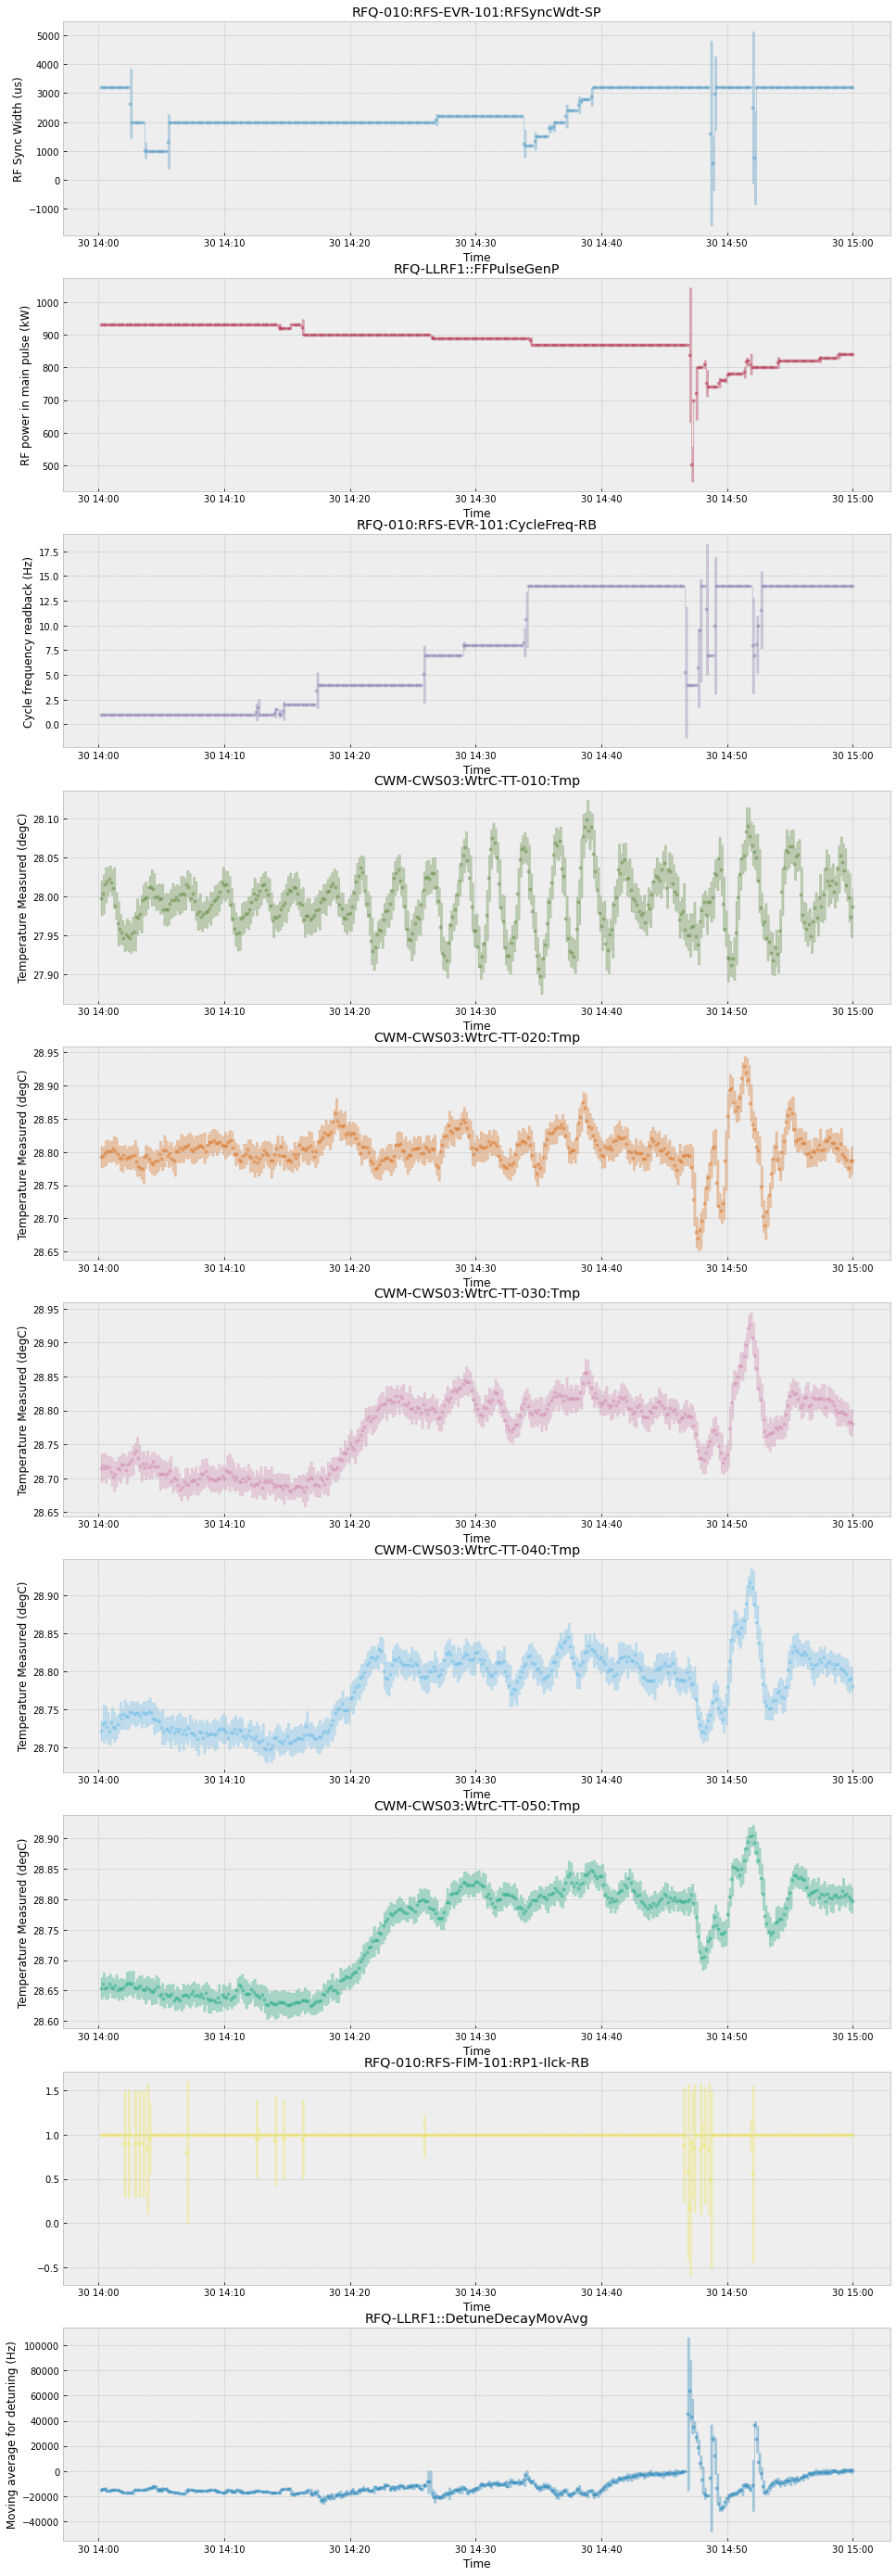

In [12]:
pvs = {}
for pvname in pv_names:
    pv = ah.get_data(pvname)
    pvs[pvname]=pv

plot_pvs(pvs)



n=0
pvname=temperature_names[0]
#pv = PV(tpv.data,tpv.lastmeta,tpv.meta,tpv.cnxlost)
#reduced = pv.bin(10)
pv[n] = ah.get_data(pvname)
pv

In [1]:
pv = pvs[vane]
#plot_pvs(pvs)
pv.lastmeta.NAME
pv.plot()



NameError: name 'pvs' is not defined

In [304]:
pvdict = {pv.lastmeta.NAME:pv.bindata for pv in pvs}
df = pd.concat(pvdict.values() ,axis=1, keys = pvdict.keys())
df

RFQ-010:RFS-EVR-101:RFSyncWdt-SP       \
                                                     wmean wstd   
Time                                                              
2021-10-30 14:00:10+02:00                           3200.0  0.0   
2021-10-30 14:00:20+02:00                           3200.0  0.0   
2021-10-30 14:00:30+02:00                           3200.0  0.0   
2021-10-30 14:00:40+02:00                           3200.0  0.0   
2021-10-30 14:00:50+02:00                           3200.0  0.0   
...                                                    ...  ...   
2021-10-30 14:59:20+02:00                           3200.0  0.0   
2021-10-30 14:59:30+02:00                           3200.0  0.0   
2021-10-30 14:59:40+02:00                           3200.0  0.0   
2021-10-30 14:59:50+02:00                           3200.0  0.0   
2021-10-30 15:00:00+02:00                           3200.0  0.0   

                          RFQ-LLRF1::FFPulseGenP       \
                                           wmean wstd   
Time                                                    
2021-10-30 14:00:10+02:00                  930.0  0.0   
2021-10-30 14:00:20+02:00                  930.0  0.0   
2021-10-30 14:00:30+02:00                  930.0  0.0   
2021-10-30 14:00:40+02:00                  930.0  0.0   
2021-10-30 14:00:50+02:00                  930.0  0.0   
...                                          ...  ...   
2021-10-30 14:59:20+02:00                  840.0  0.0   
2021-10-30 14:59:30+02:00                  840.0  0.0   
2021-10-30 14:59:40+02:00                  840.0  0.0   
2021-10-30 14:59:50+02:00                  840.0  0.0   
2021-10-30 15:00:00+02:00                  840.0  0.0   

                          RFQ-010:RFS-EVR-101:CycleFreq-RB       \
                                                     wmean wstd   
Time                                                              
2021-10-30 14:00:10+02:00                         0.999994  0.0   
2021-10-30 14:00:20+02:00                         0.999994  0.0   
2021-10-30 14:00:30+02:00                         0.999994  0.0   
2021-10-30 14:00:40+02:00                         0.999994  0.0   
2021-10-30 14:00:50+02:00                         0.999994  0.0   
...                                                    ...  ...   
2021-10-30 14:59:20+02:00                        13.999913  0.0   
2021-10-30 14:59:30+02:00                        13.999913  0.0   
2021-10-30 14:59:40+02:00                        13.999913  0.0   
2021-10-30 14:59:50+02:00                        13.999913  0.0   
2021-10-30 15:00:00+02:00                        13.999913  0.0   

                          CWM-CWS03:WtrC-TT-010:Tmp            \
                                              wmean      wstd   
Time                                                            
2021-10-30 14:00:10+02:00                 27.998491  0.011228   
2021-10-30 14:00:20+02:00                 28.003673  0.012561   
2021-10-30 14:00:30+02:00                 28.015339  0.011384   
2021-10-30 14:00:40+02:00                 28.019692  0.009219   
2021-10-30 14:00:50+02:00                 28.023541  0.008330   
...                                             ...       ...   
2021-10-30 14:59:20+02:00                 28.034154  0.013933   
2021-10-30 14:59:30+02:00                 28.014322  0.009907   
2021-10-30 14:59:40+02:00                 27.998895  0.015498   
2021-10-30 14:59:50+02:00                 27.973539  0.013042   
2021-10-30 15:00:00+02:00                 27.986878  0.011816   

                          CWM-CWS03:WtrC-TT-020:Tmp            \
                                              wmean      wstd   
Time                                                            
2021-10-30 14:00:10+02:00                 28.792703  0.007996   
2021-10-30 14:00:20+02:00                 28.793514  0.007611   
2021-10-30 14:00:30+02:00                 28.798843  0.009362   
2021-10-30 14:00:40+02:00                 28.801